# Binaural synthesis

Humans can localize the distance and angular position of sound sources by extracting and interpreting acoustic cues from the acoustic pressure signals arriving at the left and right ear.
This is possible because the incoming sound is altered depending on its direction of incidence due to reflections, diffraction, and resonances caused by the outer ear (pinna), head, and torso.
The ear signals are termed _binaural_ signals.
If binaural signals are perfectly reproduced at the ears of a listener, for example via headphone playback, this will evoke an auditory illusion of a virtual sound source that can be placed at an arbitrary position in space.
Such a reproduction of binaural signals is termed _binaural synthesis_, and the examples below show how this can be realized with special filters and anechoic audio content.

## HRTF dataset

A valid way to describe all linear sound transformations caused by torso, head, and pinna is using so-called “head-related transfer functions” (HRTFs).
For each direction of sound incidence from a sound source to a human receiver, two transfer functions exist (one for the left and one for the right ear), combined into a two-channel HRTF in the frequency domain.
Combining all directions into a single database is commonly called an HRTF dataset.
The time domain version of HRTFs are also known as "head-related impulse responses" (HRIRs).

In [1]:
%matplotlib inline
# import the required packages
import pyfar as pf
import numpy as np
import warnings
import matplotlib.pyplot as plt

# load an example HRIR dataset
hrirs, sources = pf.signals.files.head_related_impulse_responses(
    position='horizontal', diffuse_field_compensation=True)

Here we are loading the included HRIR dataset from the FABIAN dummy head by [Brinkmann _et al._](https://depositonce.tu-berlin.de/items/3b423df7-a764-4ce1-9065-4e6034bba759).
pyfar includes a [method to load specific HRIRs from the dataset](https://pyfar.readthedocs.io/en/stable/modules/pyfar.signals.files.html#pyfar.signals.files.head_related_impulse_responses).

First, we will plot all possible source locations that are contained in the dataset.

<Axes3D: xlabel='x in m', ylabel='y in m', zlabel='z in m'>

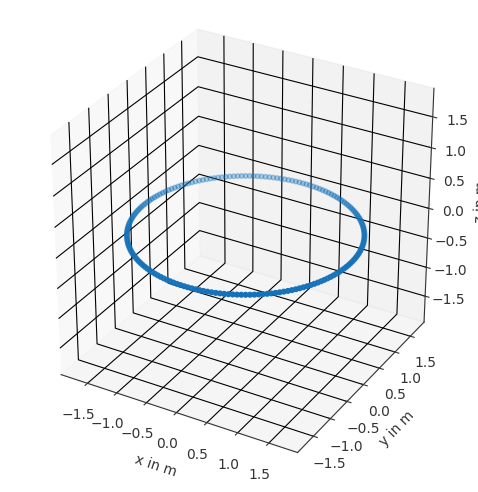

In [2]:
sources.show()

As suggested by the call to `pf.signals.files.head_related_impulse_responses` only the horizontal plane is contained in the loaded dataset.
In practice, an HRIR dataset usually contains more source positions covering the whole sphere around the listener.

Using the pyfar coordinates, <!-- LINK TODO --> a specific direction can be selected from the dataset.

<Axes3D: xlabel='x in m', ylabel='y in m', zlabel='z in m'>

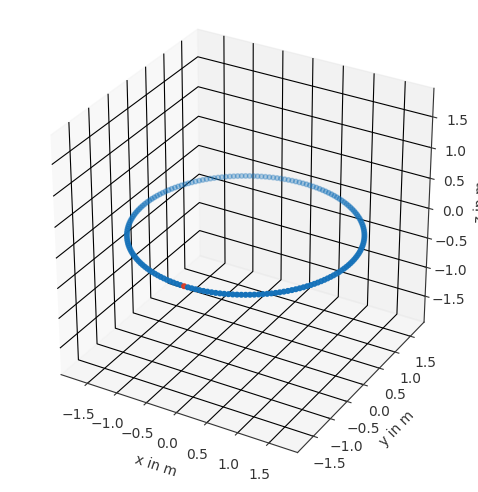

In [3]:
# define the direction of the desired sound source; here, we choose the
# right direction
elevation = 0
azimuth = -np.pi/2 # -90 degrees
radius = 2

desired_direction = pf.Coordinates.from_spherical_elevation(
    azimuth, elevation, radius
)

index, _ = sources.find_nearest(desired_direction)

sources.show(index)

In the plot, the selected direction is marked with a red dot.

With an HRIR selected, we can plot it in the time and frequency domain.
As expected, time differences and frequency dependent level differences are visible.


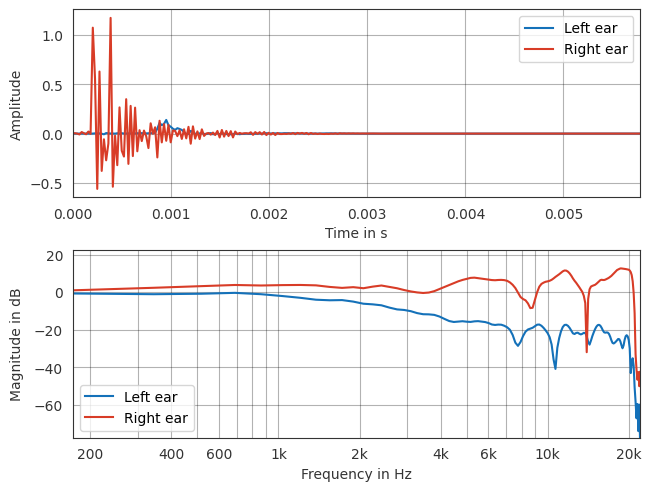

In [4]:
ax = pf.plot.time_freq(hrirs[index], label=["Left ear", "Right ear"])
ax[0].legend()
ax[1].legend()
plt.show()

## Creating a binaural synthesis

The binaural synthesis is done by convolving a mono, anechoic signal with an HRIR.
The following code shows how to do this with pyfar.

First, the audio signal is loaded and plotted in the time domain.

Loading castanets data. This is only done once.


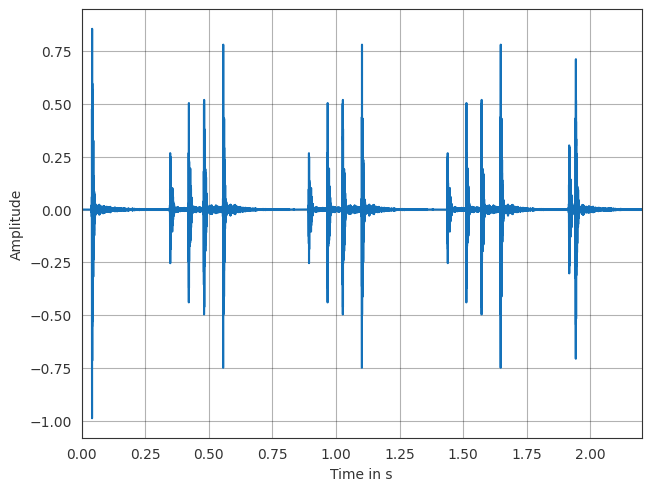

In [5]:
castanets = pf.signals.files.castanets()

pf.plot.time(castanets)
plt.show()

Next, we will create a binaural synthesis from this signal by convolving the audio signal with an HRIR. You can listen to the result and compare it to conventional stereo rendering using amplitude panning.


<div class="alert alert-warning">
Warning

**<span style="color:red; font-size:1.3em;">Please use headphones for listening to binaural signals.</span>**
</div>

First, listen to the binaural synthesis of the source.

'Binaural audio:'

'Stereo audio:'

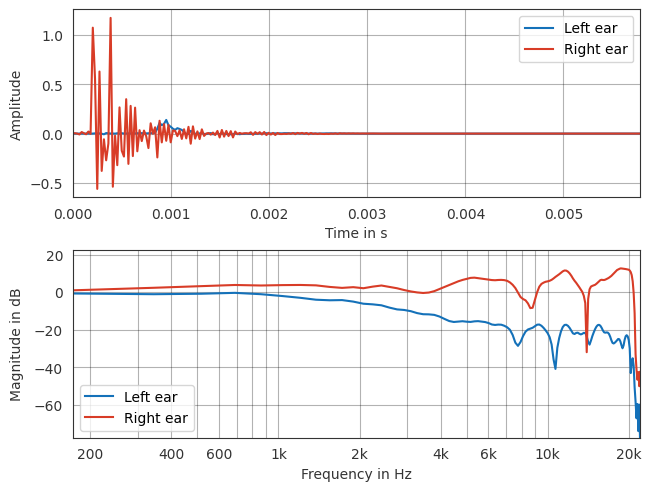

In [6]:
from IPython.display import Audio, display

# select the source position for auralization. Can be 'front', left', 'back',
# or 'right'
source_position = 'right'

# set the azimuth and stereo panning weights depending on the source position
if source_position == 'front':
    stereo_weights = [1, 1]
    azimuth = 0
elif source_position == 'left':
    stereo_weights = [1, 0]
    azimuth = np.pi / 2
elif source_position == 'back':
    stereo_weights = [1, 1]
    azimuth = np.pi
elif source_position == 'right':
    stereo_weights = [0, 1]
    azimuth = -np.pi / 2
else:
    raise ValueError(f"Invalid source position '{source_position}'")

# find the desired source position
desired_direction = pf.Coordinates.from_spherical_elevation(
    azimuth, elevation, radius)
index, _ = sources.find_nearest(desired_direction)

# generate binaural version by convolution with the HRIRs
binaural_audio = pf.dsp.convolve(castanets, hrirs[index])

# generate a stereo version by amplitude panning
stereo_audio = castanets * stereo_weights

# simple loudness adjustment based on the RMS energy
binaural_energy = np.mean(pf.dsp.rms(binaural_audio))
stereo_energy = np.mean(pf.dsp.rms(stereo_audio))
binaural_audio *= stereo_energy / binaural_energy

# render the audio
player_binaural = Audio(binaural_audio.time, rate=binaural_audio.sampling_rate)
display('Binaural audio:')
display(player_binaural)

player_stereo = Audio(stereo_audio.time, rate=stereo_audio.sampling_rate)
display('Stereo audio:')
display(player_stereo)

# plot the signal
ax = pf.plot.time_freq(hrirs[index], label=["Left ear", "Right ear"])
ax[0].legend()
ax[1].legend()
plt.show()

This is what we perceive - do you hear the same?

- **Source 'right':** The castanets are perceived at the right ear. The binaural rendering produces a source that is more externalized. This is because the binaural rendering contains information at the left ear, whereas the stereo rendering has only silence (zeros) in the left channel. As a result the stereo signal is perceived more inside the head.
- **Source 'left':** Similar effects as for the source to the right.
- **Source 'front':** The castanets are perceived in front. The binaural rendering produces a source that is more externalized. This is because the left and right channel of the binaural rendering are similar, but not identical. However the externalization is not as good as for the source to the left and right because the ear signals are more similar in this case. The left and right channel of the stereo rendering are identical and the stereo signal is thus perceived more inside the head.
- **Source 'back':** The externalization is similar as for the source to the front. However, the sound is not clearly perceived as coming from the back, a phenomenon that is known as *front-back-confusion*. This is because our auditory system is not familiar with HRTFs of the dummy head, which are used for the auralization. This could be improved by using individual HRTFs or by introducing head and/or source movements to evoke dynamic binaural cues. If you directly compare the source to the front and back, you might also be able to achieve a better localization.

## Interactive example

Last but not least, we will create an interactive example that allows you to select a source position and listen to the binaural synthesis.
In addition, we will also use two signals to demonstrate the effect of the binaural synthesis.

In [7]:
from ipywidgets import (
    GridspecLayout,
    Button,
    Layout,
    IntSlider,
    interactive_output,
)

guitar = pf.signals.files.guitar(44100)
guitar.time = guitar.time[:,:castanets.n_samples]


def convolve_with_hrir(azimuth, audio, hrirs, gain=1.0):
    # convert to radians
    azimuth = azimuth * np.pi / 180

    # define the direction of the desired sound source
    desired_direction = pf.Coordinates.from_spherical_elevation(
        azimuth, 0, 2
    )

    # find the nearest HRIRs to the desired direction
    index, _ = sources.find_nearest(desired_direction)

    # apply the HRIRs to the audio signal
    output_audio = pf.dsp.convolve(audio, hrirs[index])
    output_audio = 10 ** (gain / 20) * pf.dsp.normalize(output_audio)

    return output_audio


def interactive_demo(
        castanets_azimuth, castanets_gain, guitar_azimuth, guitar_gain):
    castanets_audio = convolve_with_hrir(
        castanets_azimuth, castanets, hrirs, castanets_gain)
    guitar_audio = convolve_with_hrir(
        guitar_azimuth, guitar, hrirs, guitar_gain)

    mixed_audio = pf.classes.audio.add(
        (castanets_audio, guitar_audio), domain="time")

    mixed_audio = pf.dsp.normalize(mixed_audio)

    display(Audio(
        mixed_audio.time, rate=mixed_audio.sampling_rate, normalize=False))

castanets_btn = Button(
    description="Castanets",
    button_style="success",
    layout=Layout(height="auto", width="auto"),
)
guitar_btn = Button(
    description="Guitar",
    button_style="success",
    layout=Layout(height="auto", width="auto"),
)
castanets_az_sl = IntSlider(
    value=90,
    min=-180,
    max=180,
    step=5,
    description="Azimuth [deg]",
    continuous_update=False,
    layout=Layout(height="auto", width="auto"),
)
castanets_gain_sl = IntSlider(
    value=0,
    min=-50,
    max=0,
    step=1,
    description="Gain [dB]",
    continuous_update=False,
    layout=Layout(height="auto", width="auto"),
)
guitar_az_sl = IntSlider(
    value=-90,
    min=-180,
    max=180,
    step=5,
    description="Azimuth [deg]",
    continuous_update=False,
    layout=Layout(height="auto", width="auto"),
)
guitar_gain_sl = IntSlider(
    value=0,
    min=-50,
    max=0,
    step=1,
    description="Gain [dB]",
    continuous_update=False,
    layout=Layout(height="auto", width="auto"),
)

grid = GridspecLayout(3, 2, height="200px")
grid[0, 0] = castanets_btn
grid[1, 0] = castanets_az_sl
grid[2, 0] = castanets_gain_sl
grid[0, 1] = guitar_btn
grid[1, 1] = guitar_az_sl
grid[2, 1] = guitar_gain_sl

out = interactive_output(
    interactive_demo,
    {
        "castanets_azimuth": castanets_az_sl,
        "castanets_gain": castanets_gain_sl,
        "guitar_azimuth": guitar_az_sl,
        "guitar_gain": guitar_gain_sl,
    },
)

display(grid, out)
plt.show()

GridspecLayout(children=(Button(button_style='success', description='Castanets', layout=Layout(grid_area='widg…

Output()

# License notice
This notebook © 2024 by [the pyfar developers](https://github.com/orgs/pyfar/people) is licensed under [CC BY 4.0](http://creativecommons.org/licenses/by/4.0/?ref=chooser-v1)

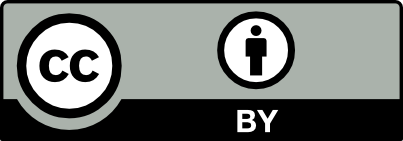


# Watermark

In [8]:
%load_ext watermark
%watermark -v -m -iv

Python implementation: CPython
Python version       : 3.10.16
IPython version      : 8.34.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.10.1
ipywidgets: 8.1.5
pyfar     : 0.7.1
IPython   : 8.34.0
numpy     : 1.26.4

